# Imports

In [1]:
from Config.util import *
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
# sys.path.insert(1, '/kaggle/input/utiletet')
# from util import *

# Dataset

In [3]:
data = pd.read_csv('Datasets/ds_salaries.csv')
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [4]:
target_col_name = 'salary'

In [5]:
data.drop_duplicates(inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2584 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           2584 non-null   int64 
 1   experience_level    2584 non-null   object
 2   employment_type     2584 non-null   object
 3   job_title           2584 non-null   object
 4   salary              2584 non-null   int64 
 5   salary_currency     2584 non-null   object
 6   salary_in_usd       2584 non-null   int64 
 7   employee_residence  2584 non-null   object
 8   remote_ratio        2584 non-null   int64 
 9   company_location    2584 non-null   object
 10  company_size        2584 non-null   object
dtypes: int64(4), object(7)
memory usage: 242.2+ KB


# Cleaning

In [7]:
data['experience_level'] = data['experience_level'].replace({
    'SE': 'Senior',
    'EN': 'Entry level',
    'EX': 'Executive level',
    'MI': 'Mid/Intermediate level',
})

data['employment_type'] = data['employment_type'].replace({
    'FL': 'Freelancer',
    'CT': 'Contractor',
    'FT' : 'Full-time',
    'PT' : 'Part-time'
})
data['company_size'] = data['company_size'].replace({
    'S': 'SMALL',
    'M': 'MEDIUM',
    'L' : 'LARGE',
})
data['remote_ratio'] = data['remote_ratio'].astype(str)
data['remote_ratio'] = data['remote_ratio'].replace({
    '0': 'On-Site',
    '50': 'Half-Remote',
    '100' : 'Full-Remote',
})

In [8]:
def assign_broader_category(job_title):
    data_engineering = ["Data Engineer", "Data Analyst", "Analytics Engineer", "BI Data Analyst", "Business Data Analyst", "BI Developer", "BI Analyst", "Business Intelligence Engineer", "BI Data Engineer", "Power BI Developer"]
    data_scientist = ["Data Scientist", "Applied Scientist", "Research Scientist", "3D Computer Vision Researcher", "Deep Learning Researcher", "AI/Computer Vision Engineer"]
    machine_learning = ["Machine Learning Engineer", "ML Engineer", "Lead Machine Learning Engineer", "Principal Machine Learning Engineer"]
    data_architecture = ["Data Architect", "Big Data Architect", "Cloud Data Architect", "Principal Data Architect"]
    management = ["Data Science Manager", "Director of Data Science", "Head of Data Science", "Data Scientist Lead", "Head of Machine Learning", "Manager Data Management", "Data Analytics Manager"]
    
    if job_title in data_engineering:
        return "Data Engineering"
    elif job_title in data_scientist:
        return "Data Science"
    elif job_title in machine_learning:
        return "Machine Learning"
    elif job_title in data_architecture:
        return "Data Architecture"
    elif job_title in management:
        return "Management"
    else:
        return "Other"

In [9]:
data['job_category'] = data['job_title'].apply(assign_broader_category)
data.drop(columns=['job_title'], inplace=True)

#### Dealing with inflation rates

In [10]:
us_inflation_rates = {2019: 0.0181, 2020: 0.0123, 2021: 0.0470, 2022: 0.065}
global_inflation_rates = {2019: 0.0219, 2020: 0.0192, 2021: 0.0350, 2022: 0.088}

def adjust_salary(row):
    year = row['work_year']
    original_salary = row['salary_in_usd']
    currency = row['salary_currency']

    if year == 2023:
        return original_salary

    adjusted_salary = original_salary
    for y in range(year, 2023):
        if currency == 'USD':
            inflation_rate = us_inflation_rates[y]
        else:
            inflation_rate = global_inflation_rates[y]

        adjusted_salary *= (1 + inflation_rate)

    return adjusted_salary


data['adjusted_salary'] = data.apply(adjust_salary, axis=1)

In [11]:
data.drop(columns=['salary', 'salary_currency', 'salary_in_usd'], inplace=True)
data = data.rename(columns={"adjusted_salary": "salary"})

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2584 entries, 0 to 3754
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   work_year           2584 non-null   int64  
 1   experience_level    2584 non-null   object 
 2   employment_type     2584 non-null   object 
 3   employee_residence  2584 non-null   object 
 4   remote_ratio        2584 non-null   object 
 5   company_location    2584 non-null   object 
 6   company_size        2584 non-null   object 
 7   job_category        2584 non-null   object 
 8   salary              2584 non-null   float64
dtypes: float64(1), int64(1), object(7)
memory usage: 201.9+ KB


In [13]:
object_cols = data.select_dtypes(include='object').columns.to_list()
data[object_cols] = data[object_cols].astype(str)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for col in object_cols:
        print(f"{col} is{'' if is_consumption(data, col, target_col_name, 0.2) else ' not'} a consumption column")

experience_level is a consumption column
employment_type is a consumption column
employee_residence is a consumption column
remote_ratio is a consumption column
company_location is a consumption column
company_size is a consumption column
job_category is a consumption column


In [14]:
data = pd.get_dummies(data, columns=object_cols)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2584 entries, 0 to 3754
Columns: 172 entries, work_year to job_category_Other
dtypes: bool(170), float64(1), int64(1)
memory usage: 489.5 KB


/var/folders/dn/jj_tz7717dz0k33tbysb91gh0000gn/T/ipykernel_80899/1806318551.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values, palette='coolwarm')


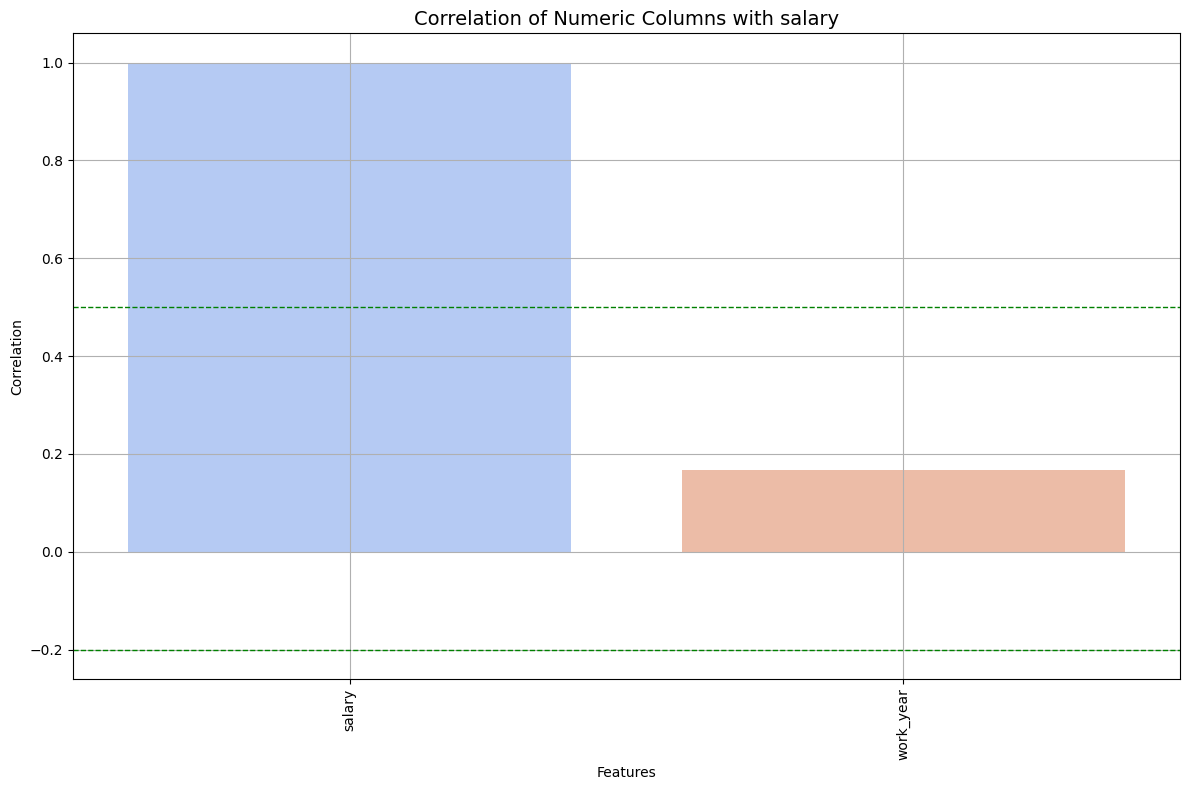

In [16]:
numeric_columns = data.select_dtypes(include=[np.number])
correlation_with_target = numeric_columns.corr()[target_col_name]
correlation_with_target = correlation_with_target.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values, palette='coolwarm')
plt.axhline(0.5, color='green', linestyle='--', linewidth=1)
plt.axhline(-0.2, color='green', linestyle='--', linewidth=1)

plt.xticks(rotation=90)
plt.title(f'Correlation of Numeric Columns with {target_col_name}', fontsize=14)
plt.ylabel('Correlation')
plt.xlabel('Features')
plt.grid(True)

plt.tight_layout()
plt.show()

# PCA

In [17]:
pca_result = PCA(n_components=1).fit_transform(data.drop(columns=[target_col_name]))
data['PCA'] = pca_result[:, 0]

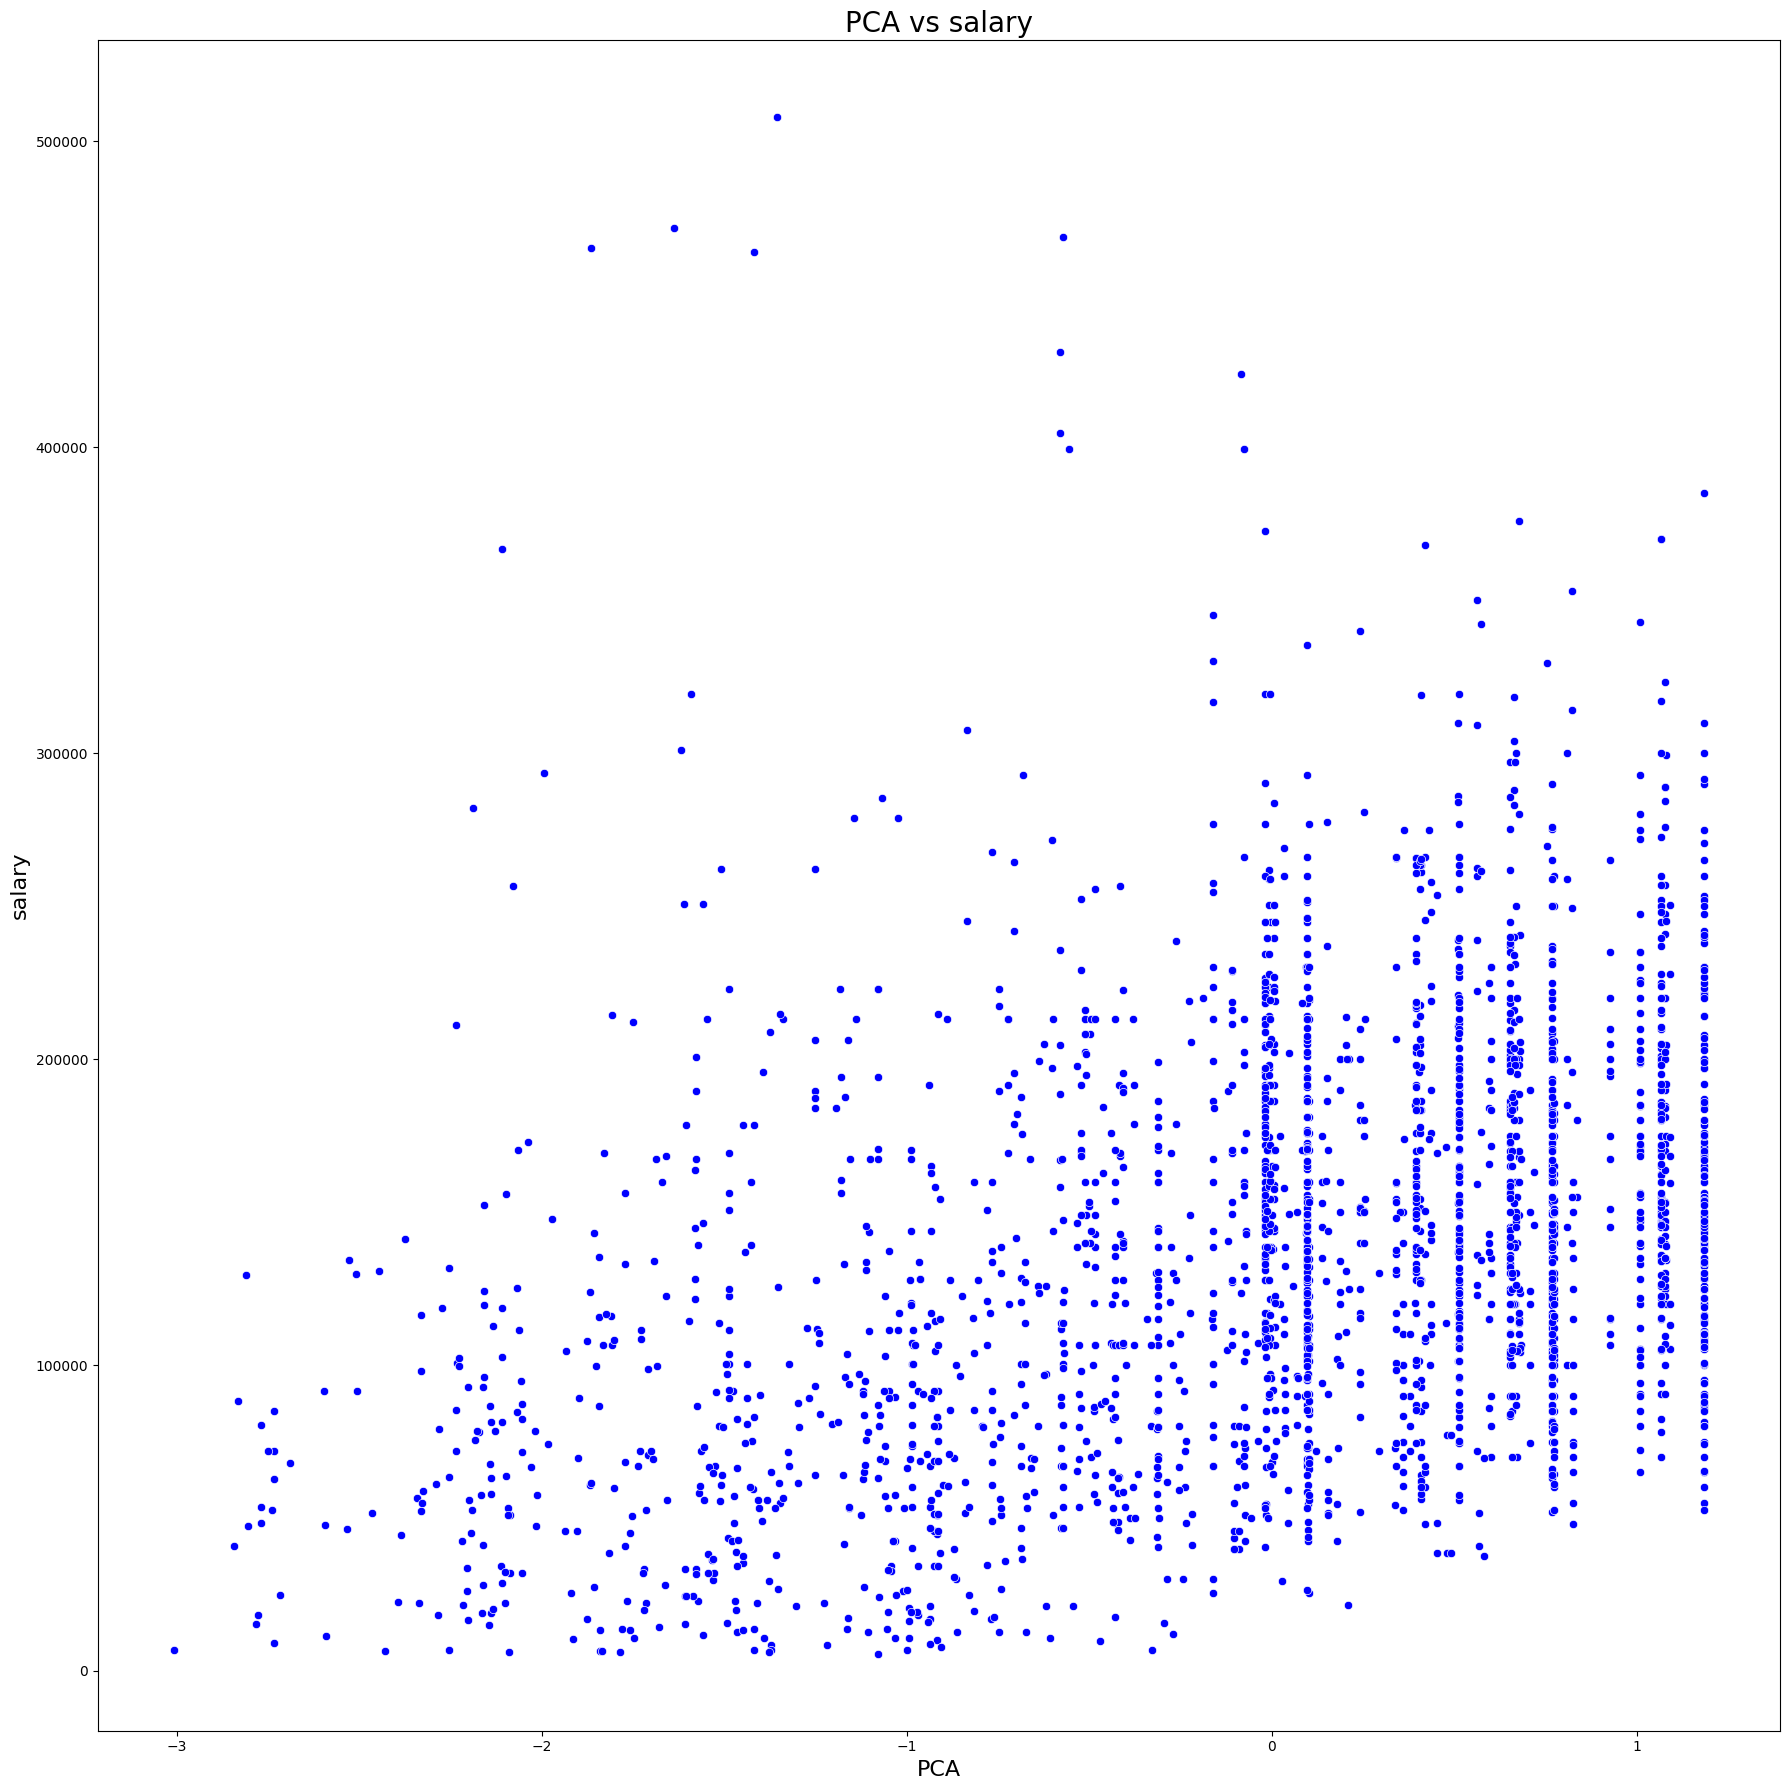

In [ ]:
fig, axe = plt.subplots(figsize=(18, 18))

sns.scatterplot(x='PCA', y=target_col_name, data=data, ax=axe, color='b')
axe.set_title(f'PCA vs {target_col_name}', fontsize=20)
axe.set_xlabel('PCA', fontsize=16)
axe.set_ylabel(target_col_name, fontsize=16)

plt.tight_layout()
plt.show()